In [3]:
import json
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results_dir = '.'
def flatten_dict(d, target_key = 'per_dataset_modality_task_dice'):
    """Flattens the nested dictionary d to tuple keys."""
    save = {}
    for key in d[target_key]:
        dictt = {    }
        for k in d[target_key][key]:
            for task in d[target_key][key][k]:
                dictt[(k, task)] = d[target_key][key][k][task]
        
        save[key] = dictt
    return save


,,,0
Baseline,MRI,prostate,0.324510
SegVol-Prior,MRI,prostate,0.845833


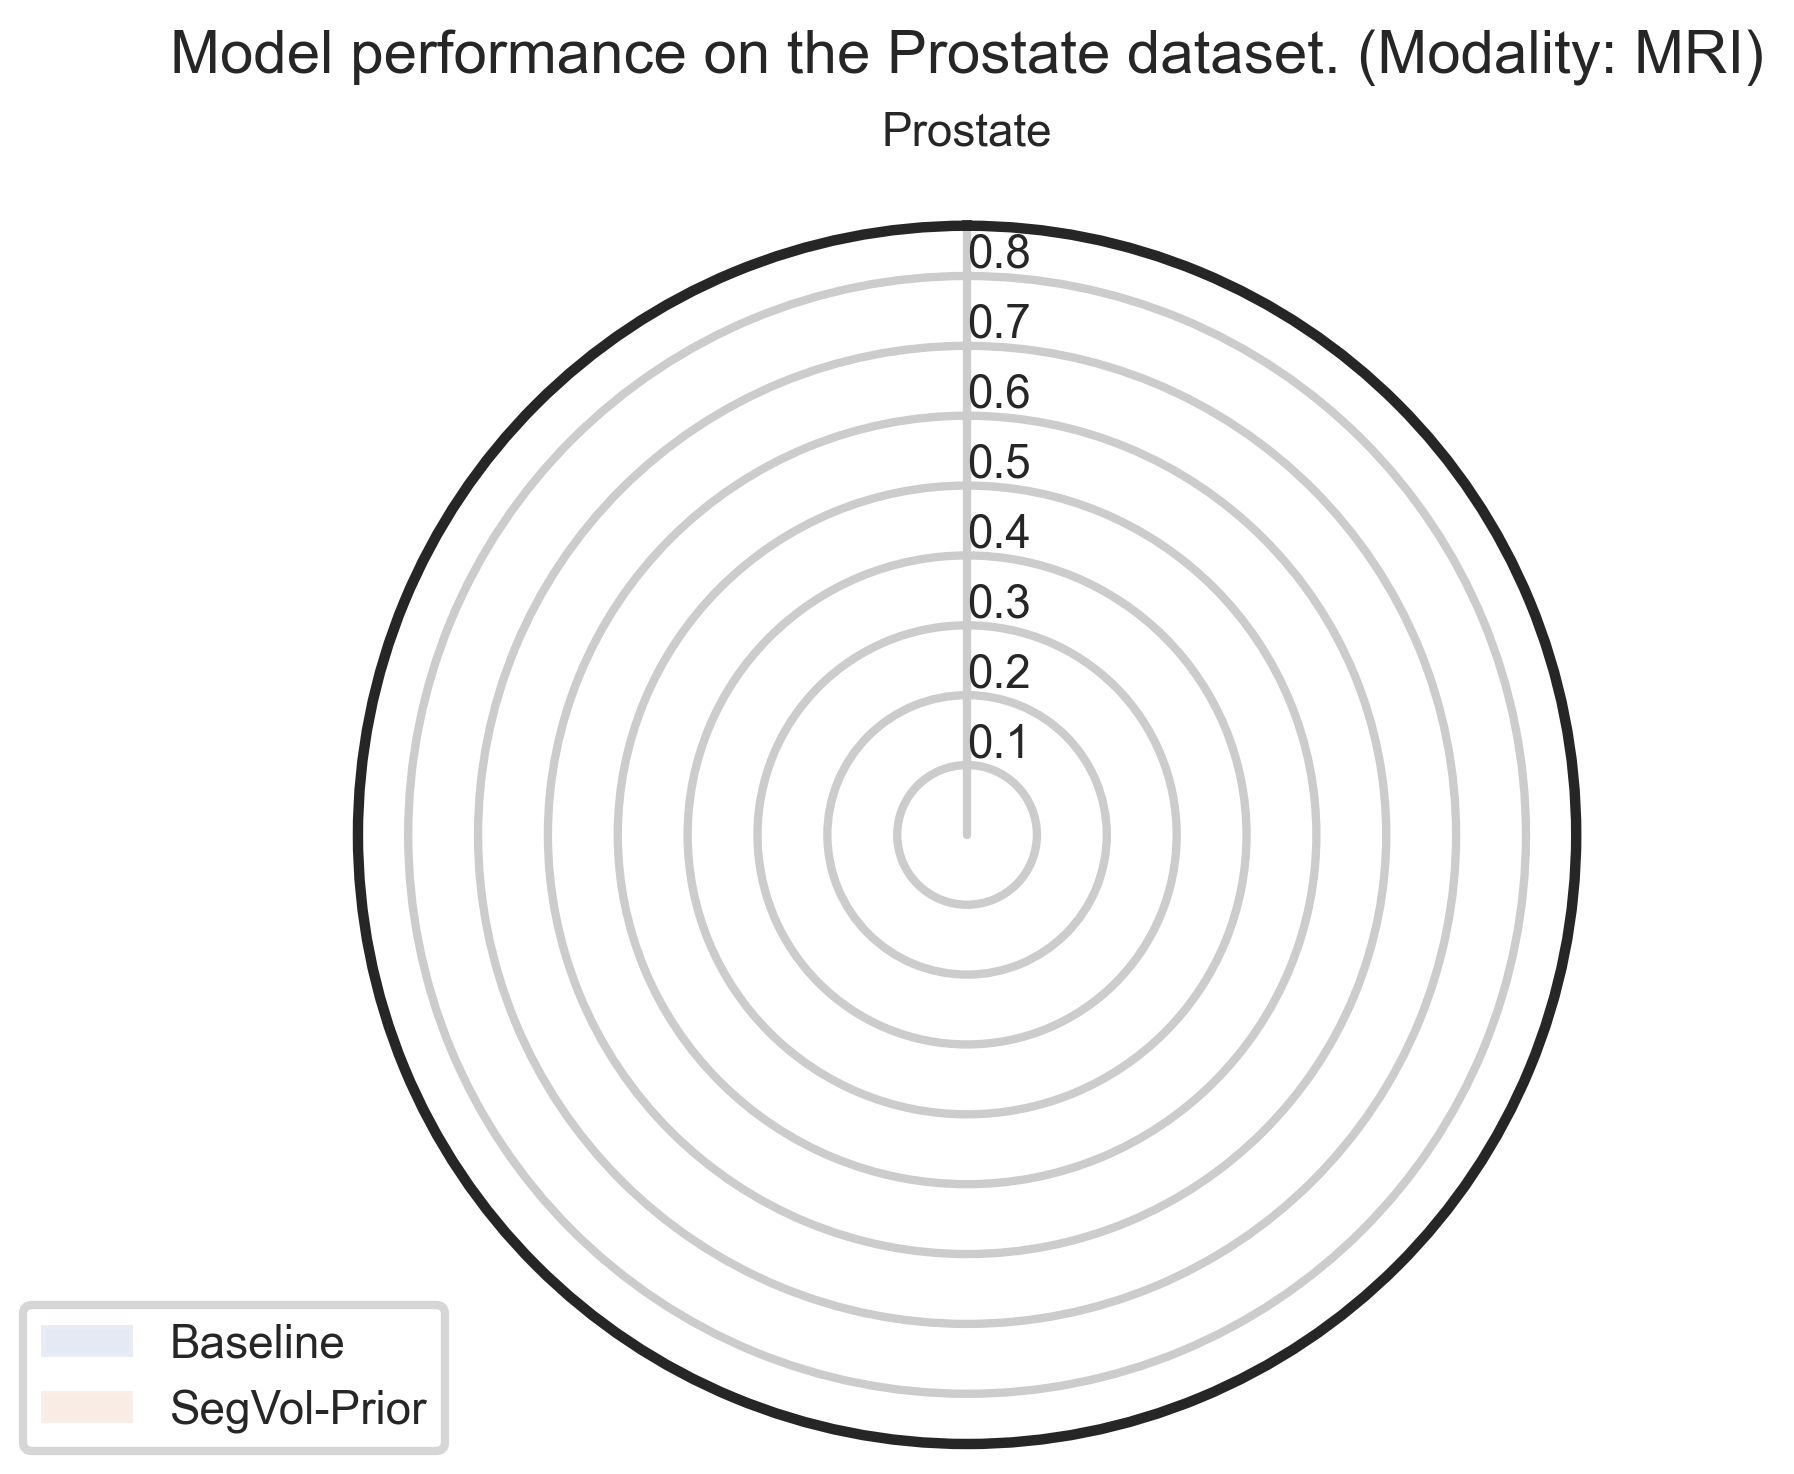

0
Baseline     MRI prostate                           0.382315
                 Enhancing Tumor                    0.236381
                 Non-Contrast-Enhancing Tumor Core  0.250000
                 Edema                              0.405408
                 right kidney                       0.904191
                 liver                              0.725064
                 arota                              0.899949
                 left adrenal gland                 0.485659
                 pancreas                           0.671785
                 esophagus                          0.567653
                 gall bladder                       0.537233
                 stomach                            0.707523
                 duodenum                           0.615844
                 left kidney                        0.781269
                 postcava                           0.778236
                 bladder                            0.250000
                 prostate/uterus                    0.250000
                 spleen                             0.775074
                 right adrenal gland                0.430416
             CT  colon cancer                       0.517814
                 liver                              0.949756
                 tumour                             0.560809
                 pancreas                           0.751137
                 spleen                             0.964386
LoRA         MRI prostate                           0.768038
                 Enhancing Tumor                    0.343241
                 Edema                              0.250000
                 Non-Contrast-Enhancing Tumor Core  0.250000
                 right kidney                       0.904617
                 left kidney                        0.871564
                 pancreas                           0.735085
                 gall bladder                       0.494653
                 spleen                             0.925730
                 prostate/uterus                    0.250000
                 right adrenal gland                0.559679
                 arota                              0.839851
                 bladder                            0.250000
                 left adrenal gland                 0.618322
                 duodenum                           0.568297
                 liver                              0.936470
                 stomach                            0.817483
                 postcava                           0.763725
                 esophagus                          0.551462
             CT  colon cancer                       0.575204
                 liver                              0.958793
                 tumour                             0.567885
                 pancreas                           0.772360
                 spleen                             0.962802
SegVol-Prior MRI prostate                           0.797154
                 Enhancing Tumor                    0.473366
                 Edema                              0.282421
                 Non-Contrast-Enhancing Tumor Core  0.250000
                 liver                              0.936724
                 left adrenal gland                 0.585740
                 bladder                            0.250000
                 arota                              0.892555
                 gall bladder                       0.484843
                 esophagus                          0.609481
                 right kidney                       0.903139
                 right adrenal gland                0.553968
                 stomach                            0.829583
                 left kidney                        0.876734
                 pancreas                           0.756111
                 duodenum                           0.569049
                 postcava                           0.761132
                 prostate/uterus 

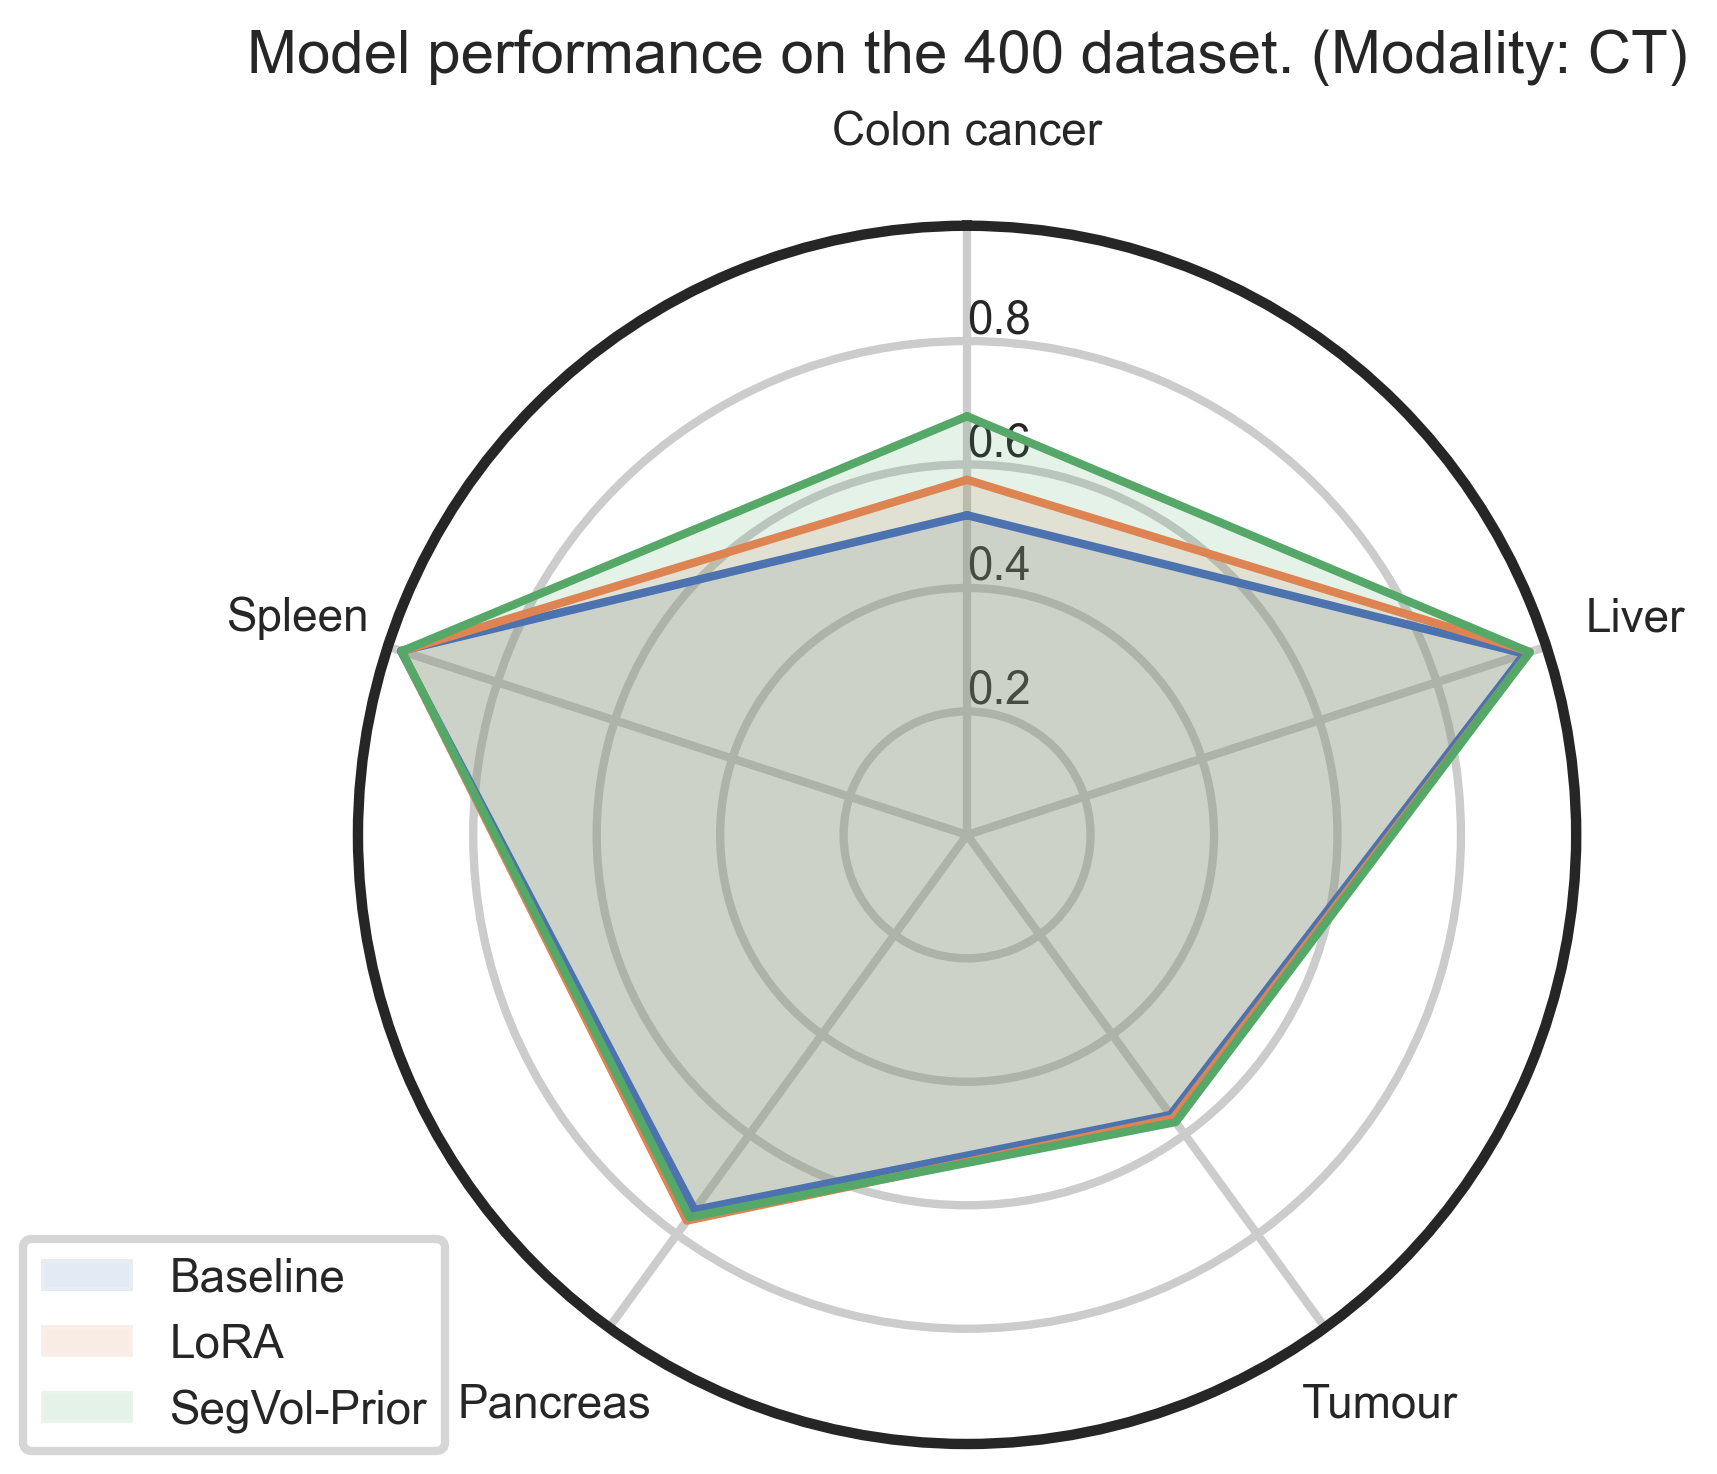

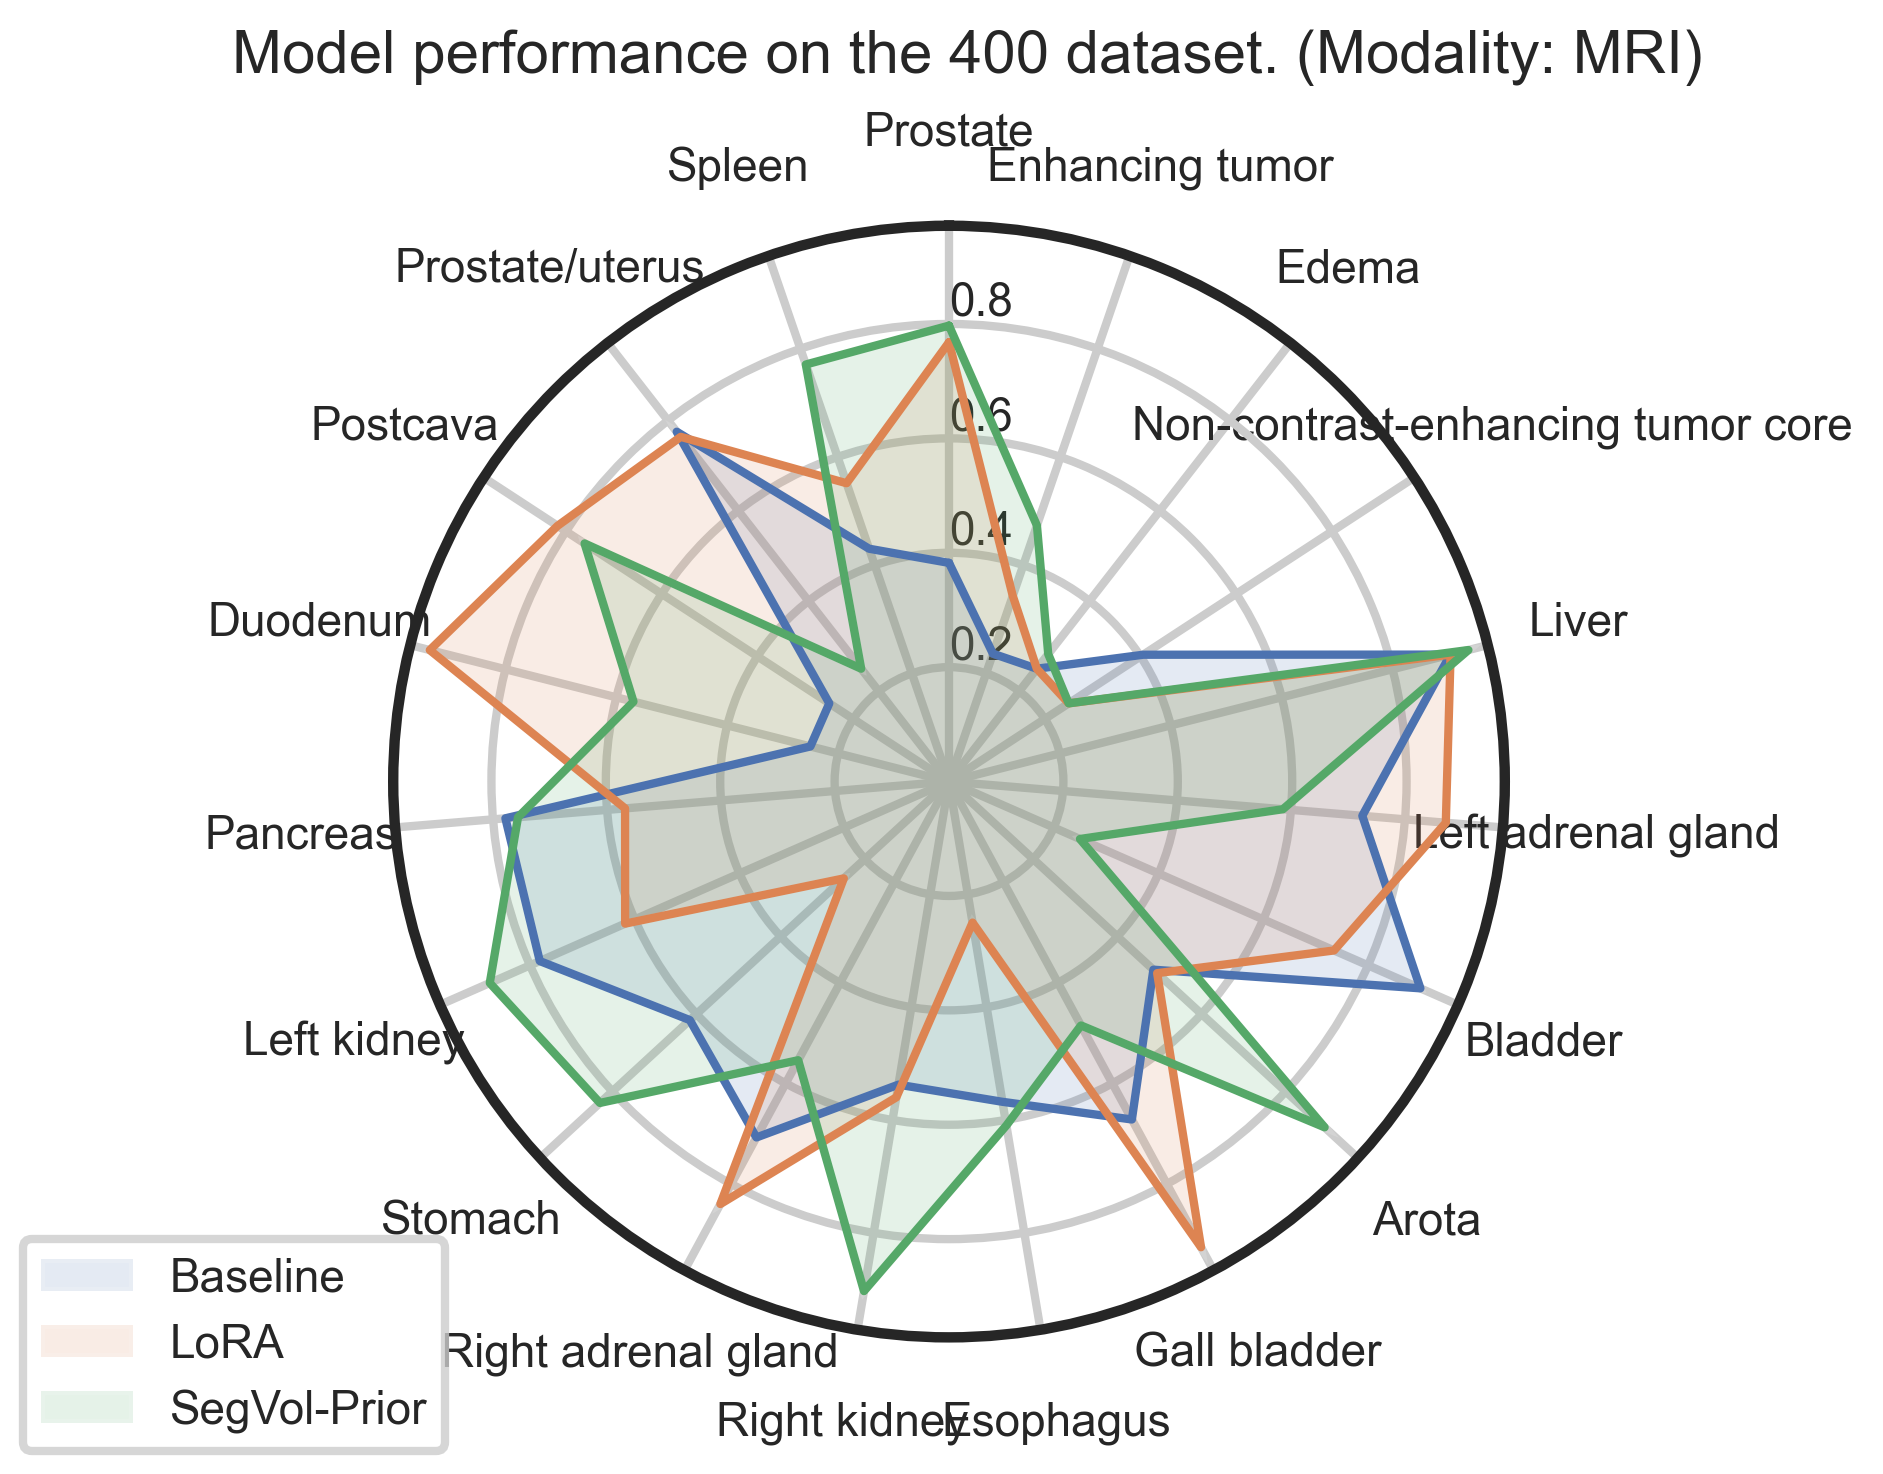

In [64]:
def draw_spider_chart(series: pd.Series, ax, label):

    # Prepare data
    labels = series.index
    labels = list(map(str.capitalize, labels))
    values = series.values

    # Number of variables
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    # Draw one axe per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw the axes with labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Draw y-labels
    ax.set_rscale('linear')
    ax.set_rlabel_position(0)
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.15, label=label)

    return fig, ax

files = os.listdir(results_dir)
groups = defaultdict(list)
# Group files by dataset
for file in files:
    if not file.endswith('.json'):
        continue
    dataset = file.rsplit('_')[-1]
    groups[dataset] += [file]


import seaborn as sns
sns.set_theme(
    context="poster",
    style="ticks",
    font_scale=0.5,
    rc={"figure.dpi": 300, "figure.constrained_layout.use": True, "lines.linewidth": 3},
)

for dataset, files in groups.items():
    dfs = []
    names = []
    for file in sorted(files):
        with open(os.path.join(results_dir, file), 'r') as f:
            data = json.load(f)
            data = flatten_dict(data)
            df = pd.DataFrame.from_dict(data, orient='index')
            
            df = df.dropna(axis=1, how='all')
            df = df.agg('mean')
            dfs.append(df)
            names.append(file.split('_')[0])
        
    df = pd.concat(dfs, sort=True,keys=names)
    df = pd.DataFrame(df) # don't think about it
    pd.DataFrame
    df [df < 0.2] = 0.25 # Add smoothing
    # df = df.fillna(0.1)
    # df = df[df > 0.2]
    # df = df.dropna(how='all', axis=1)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)
    # CT or MRI
    for mod in df.index.levels[1]:
        fig, axs = plt.subplots(subplot_kw=dict(polar=True))
        for i, name in enumerate(names):
            _, ax = draw_spider_chart(df.loc[name].loc[mod], axs, name)
            # axs[i].set_label(mod)
        # axs.legend(names)
        fig.legend(loc='lower left')
        # axs.set_title(f'Model performance on the {dataset[:-5].capitalize()} dataset. (Modality: {mod})')
        fig.suptitle(f'Model performance on the {dataset[:-5].capitalize()} dataset. (Modality: {mod})')
        plt.show()

# pd.DataFrame(df).index.levels[1]
# Show the plot
# plt.show()


In [34]:
for dataset, files in groups.items():
    dfs = []
    names = []
    for file in sorted(files):
        with open(os.path.join(results_dir, file), 'r') as f:
            data = json.load(f)
            data = flatten_dict(data)
            df = pd.DataFrame.from_dict(data, orient='index')
            
            df = df.dropna(axis=1, how='all')
            df = df.agg('mean')
            dfs.append(df)
            names.append(file.split('_')[0])

df = pd.concat(dfs, sort=True,keys=names)
df = pd.DataFrame(df) # don't think about it
df = df[df > 0.1]
df = df.dropna(how='all')
# How to pivot the third level of the index to columns
df = df.unstack(level=2)

# Remove the first level of the column index
df.columns = df.columns.droplevel(0)
df.columns = [col.capitalize() for col in df.columns]
# Split the table into two since its too long
df1 = df.iloc[:, :9]
df1 = df1.reset_index(1)
df2 = df.iloc[:, 9:]
df2 = df2.reset_index(1)

print(df1.to_markdown().replace('nan', '   ').replace("level_1", "Modality"))
print(df2.to_markdown().replace('nan', '   ').replace("level_1", "Modality"))

|              | Modality   |   Prostate |   Enhancing tumor |   Non-contrast-enhancing tumor core |      Edema |   Right kidney |    Liver |      Arota |   Left adrenal gland |   Pancreas |
|:-------------|:----------|-----------:|------------------:|------------------------------------:|-----------:|---------------:|---------:|-----------:|---------------------:|-----------:|
| Baseline     | CT        |            |                   |                                     |            |                | 0.949756 |            |                      |   0.751137 |
| Baseline     | MRI       |   0.382315 |          0.236381 |                            0.154182 |   0.405408 |       0.904191 | 0.725064 |   0.899949 |             0.485659 |   0.671785 |
| LoRA         | CT        |            |                   |                                     |            |                | 0.958793 |            |                      |   0.77236  |
| LoRA         | MRI       |   0.768038 |        